# Solve for transition path in Ramsey-model

**Table of contents**<a id='toc0_'></a>    
- 1. [Set parameters](#toc1_)    
- 2. [Calculate steady state](#toc2_)    
- 3. [Truncated equation system](#toc3_)    
- 4. [Jacobian](#toc4_)    
- 5. [Find transition path](#toc5_)    
  - 5.1. [Low initial capital](#toc5_1_)    
  - 5.2. [Technology shock](#toc5_2_)    
  - 5.3. [Future technology shock](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebok shows how to **solve the Ramsey model in sequence space**.

Profit maximization implies the pricing equations: 

$$
\begin{align*}
r_{t}^{K} &= F_{K}(\Gamma_{t},K_{t-1},L_{t}) \\
w_{t} &= F_{L}(\Gamma_{t},K_{t-1},L_{t}) \\
\end{align*}
$$

A mutual fund owns all capital and pay a return on household deposits after depreciation: 

$$
\begin{align*}
r_{t} &= r_{t}^{K}-\delta \\
A_{t} &= K_{t} \\
\end{align*}
$$

The government choose consumpion and have a balanced budget:

$$
\begin{align*}
B_{t+1} = (1+r_{t})B_{t-1} + G_{t} - X_{t},\,\,\,\,\,B_{-1} = 0 \\
X_{t} &= G_{t} \\
\end{align*}
$$

Household maximize utility and behavior is summarized by the budget constraint and the Euler-equation: 

$$
\begin{align*}
A_{t}^{hh} &=(1+r_{t})A_{t-1}^{hh}+w_{t}L_{t}^{hh}-C_{t}^{hh} \\
u^{\prime}(C_{t}^{hh})	&=\beta(1+r_{t+1})u^{\prime}(C_{t+1}^{hh}) \\
\end{align*}
$$

where labor supply is exogenous, $L_{t}^{hh} = 1$.

Market clearing entails:

$$
\begin{align*}
A_{t} &= A_{t}^{hh} \\
L_{t} &= L_{t}^{hh} \\
Y_{t} &= C_{t}^{hh} + G_{t} + I_{t}\\
\end{align*}
$$

where $Y_t = F(\Gamma_t,K_{t-1},L_t)$ and $I_{t} = K_{t} - (1-\delta)K_{t-1}$.

In [1]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace
from copy import deepcopy
import numpy as np

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Set parameters](#toc0_)

In [2]:
par = SimpleNamespace()
par.alpha = 0.36
par.beta = 0.96
par.delta = 0.10
par.sigma = 2.0

More namespaces: 

In [3]:
ss = SimpleNamespace()
ini = SimpleNamespace()
path = SimpleNamespace()

## 2. <a id='toc2_'></a>[Calculate steady state](#toc0_)

Pricing function:

In [4]:
def rK_func(par,Gamma,K_lag):
    return Gamma*par.alpha*K_lag**(par.alpha-1)

def w_func(par,Gamma,K_lag):
    return Gamma*(1-par.alpha)*K_lag**(par.alpha)

Find steady state

In [5]:
def find_ss(par,ss,G=0):

    # a. quantities
    ss.Gamma = 1.0
    ss.X = ss.G = G
    ss.B = 0.0
    
    ss.K = ((1/par.beta-1+par.delta)/(ss.Gamma*par.alpha))**(1/(par.alpha-1))
    ss.C_hh = (1-par.delta)*ss.K+ss.Gamma*ss.K**par.alpha-ss.K-ss.G

    print(f'{ss.K = :.4f}')
    print(f'{ss.C_hh = :.4f}')

    # b. prices
    ss.rK = rK_func(par,ss.Gamma,ss.K)
    ss.r = ss.rK-par.delta
    ss.w = w_func(par,ss.Gamma,ss.K)

    print(f'{ss.rK = :.4f}')
    print(f'{ss.r = :.4f}')
    print(f'{ss.w = :.4f}')    

In [6]:
find_ss(par,ss)

ss.K = 4.2940
ss.C_hh = 1.2604
ss.rK = 0.1417
ss.r = 0.0417
ss.w = 1.0815


## 3. <a id='toc3_'></a>[Truncated equation system](#toc0_)

In [7]:
par.T = 200 # length of truncation

In [8]:
def H(par,ini,ss,path,dX=0):

    # initial / pre-determined: ini.K
    # steady state: ss.C_hh

    # shocks: path.Gamma
    # endogenous: path.K

    # dX deviation from balanced budget

    # truncation length par.T

    # a. allocate
    Gamma = path.Gamma
    K = path.K
    A = path.A = np.zeros(par.T)
    rK = path.rK = np.zeros(par.T)
    r = path.r = np.zeros(par.T)
    w = path.w = np.zeros(par.T)
    C_hh = path.C_hh = np.zeros(par.T)
    A_hh = path.A_hh = np.zeros(par.T)

    # government
    G = path.G
    X = path.X = G + dX
    B = path.B = np.zeros(par.T)

    # block 1: production firm [K_lag_ini,K -> rK,w]
    for t in range(par.T):

        if t == 0:
            K_lag = ini.K
        else:
            K_lag = K[t-1]

        rK[t] = rK_func(par,Gamma[t],K_lag)
        w[t] = w_func(par,Gamma[t],K_lag)

    # block 2: mutual fund: K,rK -> A,r
    A[:] = K
    r[:] = rK-par.delta

    # block 3: household [K_lag_ini,r,w->C,A_hh]
    for k in range(par.T): # backwards on Euler

        t = par.T-1-k

        if k == 0:  
            C_hh_plus = ss.C_hh 
            r_plus = ss.r 
        else:
            C_hh_plus = C_hh[t+1]
            r_plus = r[t+1]

        C_hh[t] = (par.beta*(1+r_plus))**(-1/par.sigma)*C_hh_plus

    for t in range(par.T): # forwards on budget constraint

        if t == 0:
            A_hh_lag = ini.K # previous clearing
        else:
            A_hh_lag = A_hh[t-1]

        A_hh[t] = (1+r[t])*A_hh_lag + w[t] - C_hh[t] - X[t]      

    # block 4: market clearing
    path.clearing_A = A-A_hh

    # extra: government debt
    for t in range(par.T):

        if t == 0:
            B_lag = ss.B
        else:
            B_lag = B[t-1]
        
        B[t] = (1+r[t])*B_lag + X[t] - G[t]

Test errors are zero with steady state input:

In [9]:
path.Gamma = np.repeat(ss.Gamma,par.T)
path.G = np.repeat(ss.G,par.T)
path.K = np.repeat(ss.K,par.T)

H(par,ss,ss,path)
assert np.allclose(path.clearing_A,0.0) 

## 4. <a id='toc4_'></a>[Jacobian](#toc0_)

In [10]:
def calc_jac(par,ss,path,Delta=1e-4):
    
    jac = np.zeros((par.T,par.T))

    for s in range(par.T):

        K = np.repeat(ss.K,par.T)
        K[s] += Delta

        path.Gamma = np.repeat(ss.Gamma,par.T)
        path.G = np.repeat(ss.G,par.T)
        path.K = K
        H(par,ss,ss,path)
        jac[:,s] = path.clearing_A/Delta

    return jac

In [11]:
jac = calc_jac(par,ss,path)

## 5. <a id='toc5_'></a>[Find transition path - Technology shock](#toc0_)

In [12]:
from GEModelTools import broyden_solver

In [13]:
def obj_(x,par,ini,ss,path):
    path.K = x
    H(par,ini,ss,path)
    return path.clearing_A

### 5.1. <a id='toc5_1_'></a>[Low initial capital](#toc0_)

In [14]:
path.Gamma = np.repeat(ss.Gamma,par.T)
ini = SimpleNamespace(K=ss.K*0.75)
obj = lambda x: obj_(x,par,ini,ss,path)

K_guess = np.repeat(ss.K,par.T)
K = broyden_solver(obj,K_guess,jac,do_print=True)
_ = obj(K) # final evaluation

 it =   0 -> max. abs. error = 3.82e+03
 it =   1 -> max. abs. error = 9.96e+01
 it =   2 -> max. abs. error = 1.45e+01
 it =   3 -> max. abs. error = 3.05e-01
 it =   4 -> max. abs. error = 1.00e-02
 it =   5 -> max. abs. error = 3.33e-04
 it =   6 -> max. abs. error = 6.66e-06
 it =   7 -> max. abs. error = 5.28e-08
 it =   8 -> max. abs. error = 4.64e-10


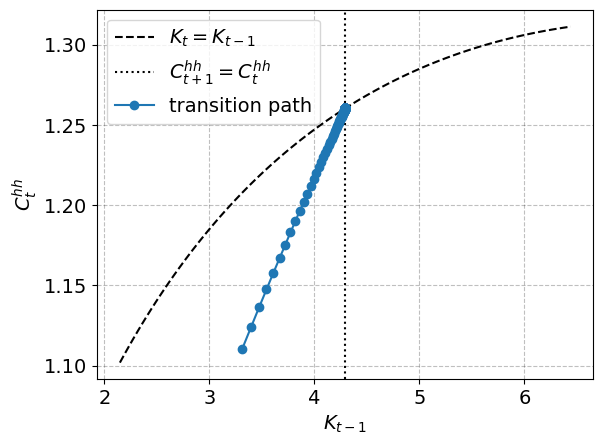

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

K_lag = np.linspace(ss.K/2,ss.K*1.5,100)
K_constant = (1-par.delta)*K_lag+ss.Gamma*K_lag**par.alpha-K_lag

ax.plot(K_lag,K_constant,ls='--',label='$K_{t}=K_{t-1}$',color='black')
ax.axvline(ss.K,ls=':',label='$C^{hh}_{t+1}=C^{hh}_t$',color='black')

ax.plot(path.K,path.C_hh,'-o',label='transition path')

ax.set_xlabel('$K_{t-1}$')
ax.set_ylabel('$C^{hh}_{t}$')
ax.legend(frameon=True)
fig.savefig('figs/K_ini_lag.pdf')

### 5.2. <a id='toc5_2_'></a>[Technology shock](#toc0_)

In [16]:
path.Gamma = ss.Gamma + 0.01*ss.Gamma*0.95**np.arange(par.T)
ini = ss
obj = lambda x: obj_(x,par,ini,ss,path)

K_guess = np.repeat(ss.K,par.T)
K = broyden_solver(obj,K_guess,jac,do_print=True)
_ = obj(K)

 it =   0 -> max. abs. error = 1.29e+03
 it =   1 -> max. abs. error = 1.69e+01
 it =   2 -> max. abs. error = 1.70e-01
 it =   3 -> max. abs. error = 1.53e-02
 it =   4 -> max. abs. error = 1.27e-05
 it =   5 -> max. abs. error = 3.83e-06
 it =   6 -> max. abs. error = 1.15e-07
 it =   7 -> max. abs. error = 2.90e-09


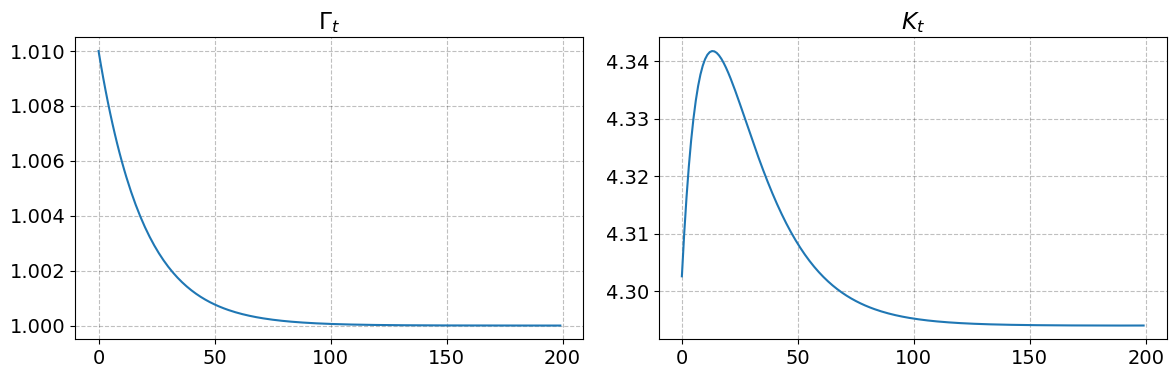

In [17]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(par.T),path.Gamma)
ax.set_title('$\Gamma_{t}$')

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(par.T),path.K)
ax.set_title('$K_{t}$')

fig.tight_layout()
fig.savefig('figs/Gamma_shock.pdf')

### 5.3. <a id='toc5_3_'></a>[Future technology shock](#toc0_)

In [18]:
path.Gamma = np.repeat(ss.Gamma,par.T)
path.Gamma[10:20] *= 1.01
ini = ss
obj = lambda x: obj_(x,par,ini,ss,path)

K_guess = np.repeat(ss.K,par.T)
K = broyden_solver(obj,K_guess,jac,do_print=True)
_ = obj(K)

 it =   0 -> max. abs. error = 6.43e+02
 it =   1 -> max. abs. error = 2.40e+00
 it =   2 -> max. abs. error = 1.34e-01
 it =   3 -> max. abs. error = 9.38e-04
 it =   4 -> max. abs. error = 1.92e-05
 it =   5 -> max. abs. error = 2.58e-07
 it =   6 -> max. abs. error = 2.49e-09


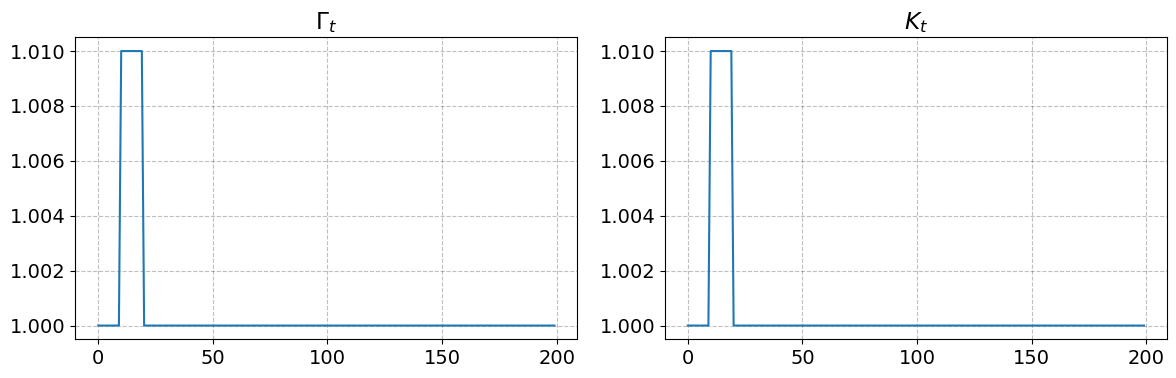

In [19]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(par.T),path.Gamma)
ax.set_title('$\Gamma_{t}$')

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(par.T),path.Gamma)
ax.set_title('$K_{t}$')

fig.tight_layout()
fig.savefig('figs/Gamma_shock_future.pdf')

## 5. <a id='toc5_'></a>[Find transition path - G shock](#toc0_)

In [20]:
find_ss(par,ss,G=0.25)
jac = calc_jac(par,ss,path)

ss.K = 4.2940
ss.C_hh = 1.0104
ss.rK = 0.1417
ss.r = 0.0417
ss.w = 1.0815


In [21]:
path.Gamma = np.repeat(ss.Gamma,par.T)
path.G = ss.G + 0.10*ss.G*0.95**np.arange(par.T)
ini = ss
obj = lambda x: obj_(x,par,ini,ss,path)

K_guess = np.repeat(ss.K,par.T)
K = broyden_solver(obj,K_guess,jac,do_print=True)
_ = obj(K)

 it =   0 -> max. abs. error = 9.58e+02
 it =   1 -> max. abs. error = 3.29e+00
 it =   2 -> max. abs. error = 8.84e-02
 it =   3 -> max. abs. error = 2.38e-03
 it =   4 -> max. abs. error = 3.72e-05
 it =   5 -> max. abs. error = 3.31e-08
 it =   6 -> max. abs. error = 2.02e-10


In [22]:
def plot_G_shock(par,ss,path,filename):

    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(1,3,1)

    K_lag = np.linspace(ss.K*0.9,ss.K*1.10,100)
    K_constant = (1-par.delta)*K_lag+ss.Gamma*K_lag**par.alpha-K_lag-ss.G

    ax.plot(K_lag,K_constant,ls='--',label='$K_{t}=K_{t-1}$',color='black')
    ax.axvline(ss.K,ls=':',label='$C^{hh}_{t+1}=C^{hh}_t$',color='black')

    ax.plot(path.K,path.C_hh,'-o',markersize=2,label='transition path')

    ax.set_xlabel('$K_{t-1}$')
    ax.set_ylabel('$C^{hh}_{t}$')
    ax.legend(frameon=True)
    ax.set_title('Phase diagram') 

    ax = fig.add_subplot(1,3,2)
    ax.plot(np.arange(par.T),path.G,label='G')
    ax.plot(np.arange(par.T),path.X,'--',label='X')
    ax.legend(frameon=True)
    ax.set_title('$G_{t}$ and $X_{t}$')

    ax = fig.add_subplot(1,3,3)
    ax.plot(np.arange(par.T),path.B)
    ax.set_title('$B_{t}$')

    fig.savefig(r'figs/{filename}.pdf')

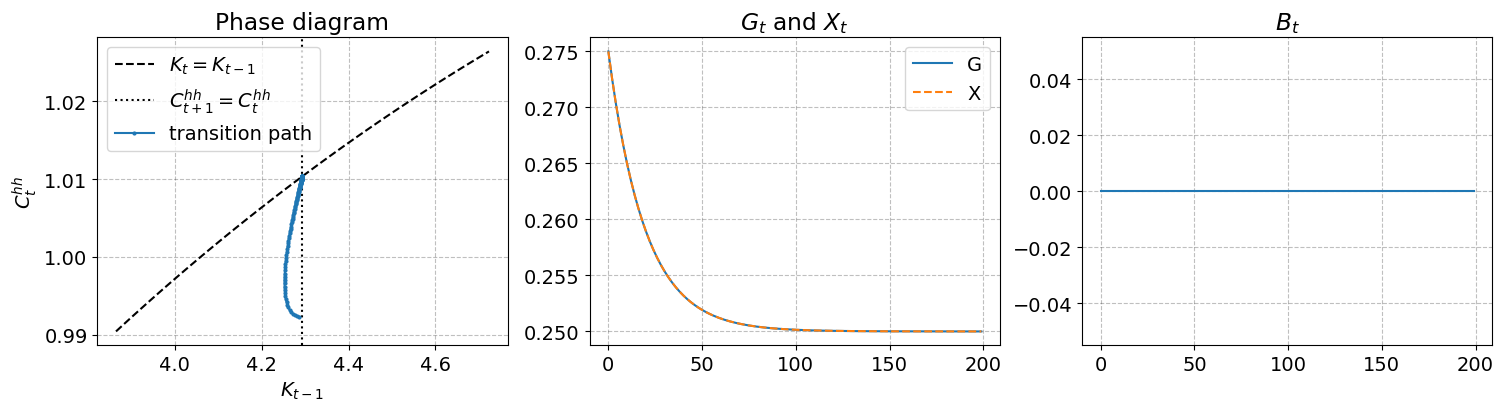

In [23]:
plot_G_shock(par,ss,path,'G_shock')

**Ricardian equivalence:**

1. Choose arbitrary path for government debt $B$ converging back to zero
2. Infer required lump-sum taxes, $X$

In [24]:
D = 10 # periods with constant lump-sum taxes

# a. debt
B = np.zeros(par.T)
for t in range(D+1):
   B_lag = B[t-1] if t > 0 else ss.B
   B[t] = (1+path.r[t])*B_lag + path.G[t]-ss.G 

B[D:] = B[D]*0.95**np.arange(par.T-10)

# b. implied lump-sum taxes
dX = np.zeros(par.T)
for t in range(par.T):
    B_lag = B[t-1] if t > 0 else ss.B
    dX[t] = (1+path.r[t])*B_lag - B[t] 

Evaluate model with updated lump-sum taxes: 

In [25]:
path_pre = deepcopy(path)

H(par,ini,ss,path,dX=dX)

assert np.allclose(path_pre.K,path.K)
assert np.allclose(path_pre.C_hh,path.C_hh)

Plot:

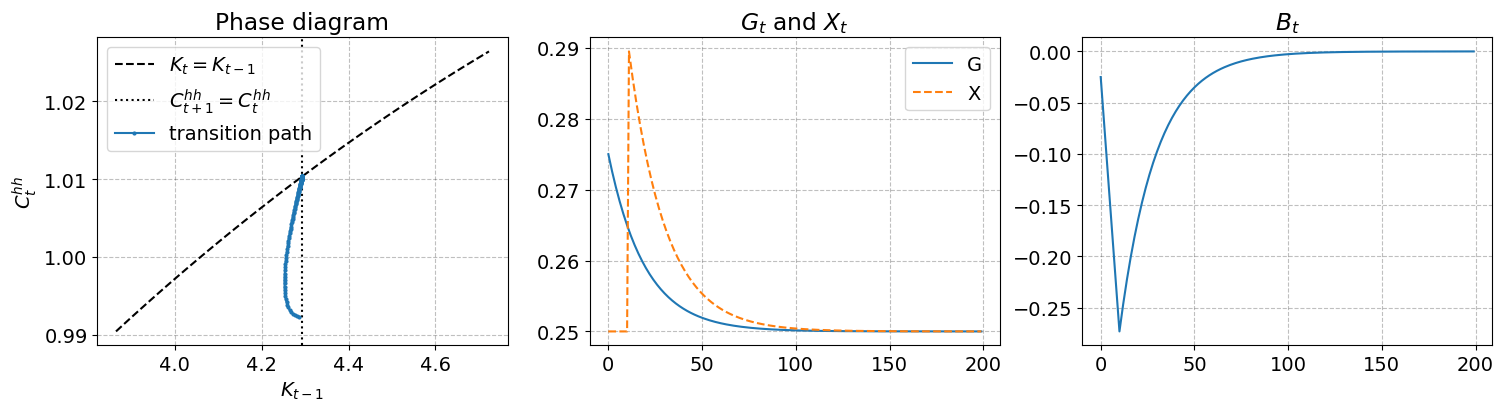

In [26]:
plot_G_shock(par,ss,path,'G_shock_alt')